# Índice

1. [Preparacion del Dataset](#preparaciondataset)

    1.1 [Visualización de los datos](#visualizaciondatos) <br>
    1.2 [Carga del Dataset](#cargadeldataset) <br>
    1.3 [Modificación de imagenes a baja y media resolución](#modimgs) <br>
    1.4 [Creación de los datasets](#creaciondatasets)
    
    - [a). Baja resolución (kxk)](#br) <br>
    - [b). Media resolución (mxm)](#mr)<br>
    - [c). Alta resolución (nxn)](#hr)
2. [Creación y Entrenamiento de modelos](#creacionentrenamientomodelos)

    2.1 [Autoencoder (Vanilla)](#ae) <br>
    2.2 [Variational Auto Encoder (VAE)](#vae) <br>
    2.3 [GAN (Sin U-Net)](#gan) <br>
    2.4 [GAN (U-Net o cGAN o pix2pix)](#cgan) <br>
    2.5 [SRGAN(?)](#srgan) <br>
    2.6 [ESRGAN(?)](#esrgan) <br>
3. [Comparación de modelos](#comparacionmodelos)

    3.1 [Métricas individuales](#mi) <br>
    3.2 [Tablas comparativas de métricas](#tcm) <br>
    3.3 [Comparativa de imágenes](#ci)

Imports:

In [24]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import cv2

# 1. Preparación del Dataset <a id="preparaciondataset"></a>

## 1.1 Visualización de los datos <a id="visualizaciondatos"></a>

Vamos a abrir un par de imágenes para ver el contenido del dataset.

In [25]:
show_image = Image.open("./Dataset/DIV2K_train_HR/0001.png")
show_image.size

(2040, 1404)

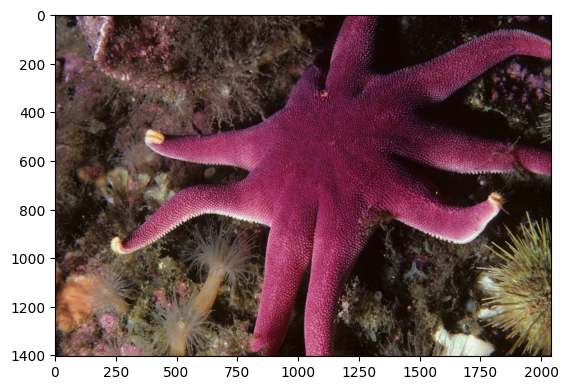

In [26]:
plt.imshow(show_image)

In [27]:
show_image = Image.open("./Dataset/DIV2K_train_HR/0124.png")
show_image.size

(1356, 2040)

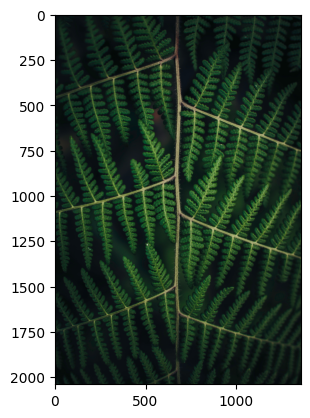

In [28]:
plt.imshow(show_image)

Como se puede observar, las imágenes tienen un tamaño constante de 2040 de ancho o de alto.

## 1.2 Carga del Dataset <a id="cargadeldataset"></a>

Se definen algunas variables globales como las rutas de los directorios del dataset

In [29]:
DIV2K_TRAIN_HR_PATH = "Dataset/DIV2K_train_HR/*.png"
DIV2K_VALID_HR_PATH = "Dataset/DIV2K_valid_HR/*.png"

En este caso se está haciendo uso del dataset DIV2k (Explicar un poco mas sobre este dataset)

Se define el número de batch

In [30]:
BATCH_SIZE = 1

## 1.3 Modificación de imagenes a baja y media resolución <a id="modimgs"></a>

Esta función la he encontrado aquí: https://gist.github.com/blzq/c87d42f45a8c5a53f5b393e27b1f5319

In [31]:
def gaussian_blur(img, kernel_size=11, sigma=50):
    def gauss_kernel(channels, kernel_size, sigma):
        ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
        xx, yy = tf.meshgrid(ax, ax)
        kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels])
        return kernel

    gaussian_kernel = gauss_kernel(tf.shape(img)[-1], kernel_size, sigma)
    gaussian_kernel = gaussian_kernel[..., tf.newaxis]

    img = tf.expand_dims(img, axis=0)  # Expandir la dimensión del tensor de entrada
    img_blurred = tf.nn.depthwise_conv2d(img, gaussian_kernel, [1, 1, 1, 1],
                                          padding='SAME', data_format='NHWC')
    img_blurred = tf.squeeze(img_blurred, axis=0)  # Eliminar la dimensión extra agregada

    return img_blurred

In [32]:
def corrupt_part_of_image(image, noise_level=0.1, corruption_level=0.35):
    
    mask = tf.random.uniform(tf.shape(image)[:2]) < corruption_level
    noise = tf.random.normal(tf.shape(image), stddev=noise_level)
    noise = (noise + 1.0) / 2.0
    corrupted_image = tf.where(mask[..., tf.newaxis], tf.clip_by_value(image + noise, 0.0, 1.0), image)
    
    return corrupted_image

In [33]:
def low_res(img):
    img = tf.image.resize(img,size=(256,256))
    img = gaussian_blur(img)
    img = corrupt_part_of_image(img)
    return img

In [34]:
def med_res(img):
    img = tf.image.resize(img,size=(512,512))
    img = gaussian_blur(img)
    img = corrupt_part_of_image(img)
    return img

Función para cargar una imagen png y la transforma a float32

In [35]:
def load(input_path):
    img = tf.io.read_file(input_path)
    img = tf.cast(tf.image.decode_png(img,channels=3),tf.float32)
    return img

Función para normalizar la imagen

In [36]:
def normalize(img):
    #img = (img / 127.5) - 1 # Normalización de la imagen entre [-1 y 1]
    img = img / 255 #Normalización de la imagen entre [0 y 1]
    return img

In [37]:
#Target = Ground Truth ; Input = Imagen que se va a meter al modelo
def low_res_img_map(input_path):

    target_img = load(input_path)
    target_img = tf.image.resize(target_img,size=(1024,1024))

    input_image = low_res(target_img)

    target_img = normalize(target_img)
    input_image = normalize(input_image)

    return input_image, target_img

def med_res_img_map(input_path):

    target_img = load(input_path)
    target_img = tf.image.resize(target_img,size=(1024,1024))

    input_image = med_res(target_img)

    target_img = normalize(target_img)
    target_img = normalize(target_img)

    return input_image, target_img

def high_res_img_map(input_path):
    
    target_img = load(input_path)
    target_img = tf.image.resize(target_img,size=(1024,1024))

    target_img = normalize(target_img)

    return target_img, target_img


## 1.4 Creación de los datasets <a id="creaciondatasets"></a>

 Esta función crea un dataset con un input y un target. 

In [38]:
def create_dataset(dataset_path, res_func):
    dataset = tf.data.Dataset.list_files(str(dataset_path))
    dataset = dataset.map(res_func, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

### a). Baja resolución (kxk) <a id="br"></a>

In [39]:
low_res_train_dataset = create_dataset(DIV2K_TRAIN_HR_PATH,low_res_img_map)
low_res_valid_dataset = create_dataset(DIV2K_VALID_HR_PATH,low_res_img_map)

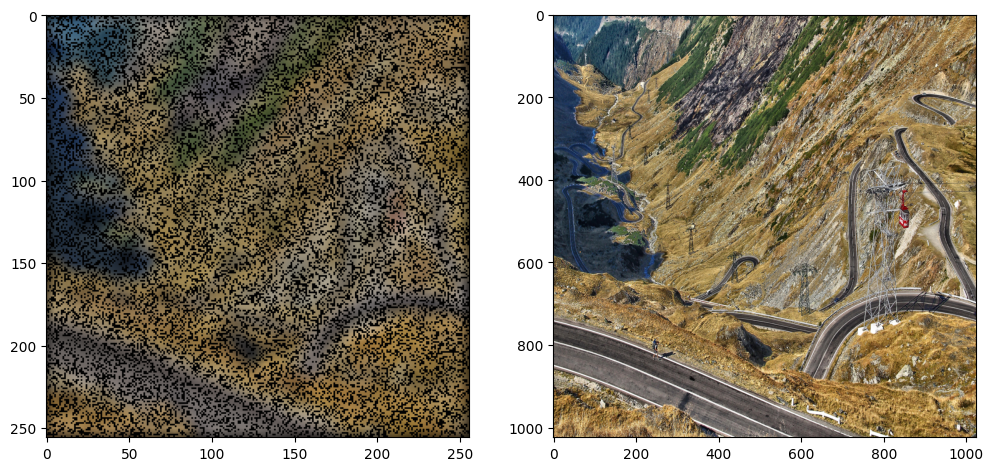

In [40]:
for a,b in low_res_train_dataset.as_numpy_iterator():
    fig, axs = plt.subplots(1, 2,figsize=(12,6))
    axs[0].imshow(a[0])
    axs[1].imshow(b[0])
    plt.show()
    break

### b). Media resolución (mxm) <a id="mr"></a>

In [41]:
med_res_train_dataset = create_dataset(DIV2K_TRAIN_HR_PATH,med_res_img_map)
med_res_valid_dataset = create_dataset(DIV2K_VALID_HR_PATH,med_res_img_map)

### c). Alta resolución (nxn) <a id="hr"></a>

In [42]:
high_res_train_dataset = create_dataset(DIV2K_TRAIN_HR_PATH,high_res_img_map)
high_res_valid_dataset = create_dataset(DIV2K_VALID_HR_PATH,high_res_img_map)

# 2. Creación y Entrenamiento de modelos <a id="creacionentrenamientomodelos"></a>

Se comprueba que se detecta la tarjeta gráfica:

In [43]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 2.1 Autoencoder (Vanilla) <a id="ae"></a>

![Auto Encoder Vanilla](./Images/latent_representation_AE.png)

In [44]:
class Autoencoder(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(None,None,3)),
            tf.keras.layers.Convolution2D(16, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Convolution2D(64, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Convolution2D(128, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Convolution2D(256, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Convolution2D(1024, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.MaxPooling2D((2, 2))
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Convolution2D(1024, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.UpSampling2D((2, 2)),
            tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.UpSampling2D((2, 2)),
            tf.keras.layers.Convolution2D(256, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.UpSampling2D((2, 2)),
            tf.keras.layers.Convolution2D(128, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.UpSampling2D((2, 2)),
            tf.keras.layers.Convolution2D(64, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.UpSampling2D((2, 2)),
            tf.keras.layers.Convolution2D(16, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.UpSampling2D((2, 2)),
            tf.keras.layers.Convolution2D(3, (3, 3), activation='linear', padding='same'),
            tf.keras.layers.UpSampling2D((2, 2)),

        ])

    def call(self, x):
        return self.decoder(self.encoder(x))

In [45]:
autoencoder = Autoencoder()

In [46]:
tf.keras.utils.plot_model(autoencoder.decoder, show_shapes=True, dpi=64)

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [47]:
autoencoder.compile(loss='mean_squared_error', optimizer='adam')
history = autoencoder.fit(low_res_train_dataset,epochs=10)

Epoch 1/10


ValueError: in user code:

    File "c:\Users\Daniel Marin\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Daniel Marin\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Daniel Marin\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Daniel Marin\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\Daniel Marin\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\Daniel Marin\anaconda3\envs\tf\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\Daniel Marin\anaconda3\envs\tf\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\Daniel Marin\anaconda3\envs\tf\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\Daniel Marin\anaconda3\envs\tf\lib\site-packages\keras\losses.py", line 1486, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 512 and 1024 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](autoencoder_1/sequential_3/up_sampling2d_13/resize/ResizeNearestNeighbor, IteratorGetNext:1)' with input shapes: [?,512,512,3], [?,1024,1024,3].


## 2.2 Variational Auto Encoder (VAE) <a id="vae"></a>

## 2.3 GAN (Sin U-Net) <a id="gan"></a>

## 2.4 GAN (U-Net o cGAN o pix2pix) <a id="cgan"></a>

## 2.5 SRGAN(?) <a id="srgan"></a>

## 2.6 ESRGAN(?) <a id="esrgan"></a>

# 3. Comparación de modelos <a id="comparacionmodelos"></a>

# 3.1 Métricas individuales <a id="mi"></a>

# 3.2 Tablas comparativas de métricas <a id="tcm"></a>

# 3.3 Comparativa de imágenes <a id="ci"></a>